In [1]:
## Exercise 1b
# 1 Comment on your solution to Exercise 1a
# markdown cells starting with <span style="color:green;font-weight:bold">Comment</span>
# 2 Comment on others' solution to Exercise 1a
# markdown cells starting with <span style="color:green;font-weight:bold">Comment</span>



In [2]:
## 3 Nearest Neighbor Classi􏰃cation on Real Data
# 3.1 Exploring the Data (3 points)

import numpy as np
from sklearn.datasets import load_digits
digits = load_digits()
print(digits.keys())
data = digits["data"]
images = digits["images"]
target = digits["target"]
target_names = digits["target_names"]

print(data.dtype)
#print(digits['DESCR'])


dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])
float64


In [3]:
# print the size of images
# the number of sample = 1797
# the size of each image = (8,8)

np.shape(data)
np.shape(images)


(1797, 8, 8)

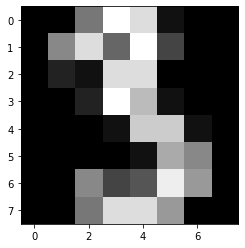

In [4]:
# Visualize one image of a 3 using the imshow

import matplotlib.pyplot as plt
img = images[3]
assert 2 == len(img.shape)
plt.figure()
plt.gray()
plt.imshow(img, interpolation="nearest") 
plt.show()


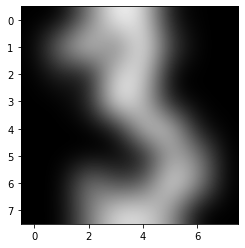

In [5]:
# Visualize by changing interpolation="bicubic" 

plt.imshow(img, interpolation="bicubic")
plt.show()


In [6]:
# Split data into train/test set

from sklearn import model_selection
X_all = data 
Y_all = target
X_train , X_test , Y_train , Y_test = model_selection.train_test_split(X_all, Y_all,test_size = 0.4, random_state = 0)


In [7]:
# 3.2 Distance function computation using loops (3 points)
# Use the X_train and X_test as input

def dist_loop(training, test):
    dist = [ np.linalg.norm(xj-xi)  for xj in training  for xi in test ]
    distm = np.array(dist, dtype=np.float64).reshape( (len(training),len(test)) )
    return distm


In [10]:
distm1 = dist_loop(training=X_train, test=X_test)
len(X_train), len(X_test)


(1078, 719)

In [11]:
np.shape(distm1)


(1078, 719)

In [12]:
# Measure the run time using dist_loop
%timeit dist_loop(training=X_train, test=X_test)


3.96 s ± 136 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
# 3.3 Distance function computation using vectorization (8 points)

def dist_vec(training, test):
    distm =  np.linalg.norm(training[ : , np.newaxis] - test, axis = 2)
    return distm


In [14]:
distm2 = dist_vec(training=X_train, test=X_test)
len(X_train), len(X_test)


(1078, 719)

In [15]:
np.shape(distm2)


(1078, 719)

In [16]:
# Measure the run time using dist_vec
%timeit dist_vec(training=X_train, test=X_test)


514 ms ± 16.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [17]:
# 3.4 Implement the k-nearest neighbor classi􏰃er (6 points)

def KNNclassifier(x_train, y_train, x_test, K):
    y_test = []
    distm = dist_vec(training = x_train, test = x_test)
    disti = np.argpartition(distm, kth = K, axis = 0)[ :K , : ]
    distv = y_train[disti]
    y_test = np.array([ np.bincount(distv[ : , v ]).argmax() for v in range(len(distv[0])) ])
    return y_test


In [18]:
def calKNNError(x_train, y_train, x_test, Y_test, K, model, stdout):
    errorA = []
    for k in K:
        if model == KNNclassifier:
            y_test = model(x_train=x_train, y_train=y_train, x_test=x_test, K=k)
        elif model == KNeighborsClassifier:
            y_test = KNeighborsClassifier(n_neighbors=k).fit(x_train, y_train).predict(x_test)
        N_test = len(Y_test)
        err = (N_test - np.sum(y_test == Y_test)) / N_test
        errorA.append( err )
        if stdout == True:
            print( "K Nearest Neighbor Classifier--> K =",k," : error rates =",round(err,5) )
    return errorA


In [19]:
# Subset the data to digit 3 and 9
# Split the subset data to train/test set

X_sub = data[ (target== 3)|(target== 9) , : ]
Y_sub = target[ (target== 3)|(target== 9) ]
X_train , X_test , Y_train , Y_test = model_selection.train_test_split(X_sub, Y_sub,test_size = 0.4, random_state = 0)


In [20]:
# Set different K = [1, 3, 5, 9, 17, 33]

K = [1, 3, 5, 9, 17, 33]


In [21]:
# Compute the error rate with different K

errorKNN = calKNNError(x_train=X_train, y_train=Y_train, x_test=X_test, Y_test=Y_test, K=K, model=KNNclassifier, stdout=True)


K Nearest Neighbor Classifier--> K = 1  : error rates = 0.00685
K Nearest Neighbor Classifier--> K = 3  : error rates = 0.00685
K Nearest Neighbor Classifier--> K = 5  : error rates = 0.0
K Nearest Neighbor Classifier--> K = 9  : error rates = 0.0137
K Nearest Neighbor Classifier--> K = 17  : error rates = 0.0137
K Nearest Neighbor Classifier--> K = 33  : error rates = 0.02055


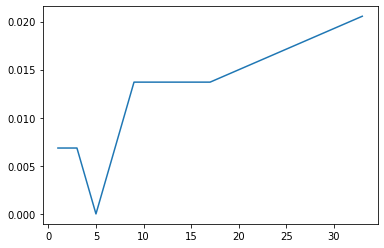

In [22]:
# Plot the dependency of the classification performance on K

plt.plot(K,errorKNN, label = "K")
plt.show()


In [23]:
# 4 Cross-validation (8 points)

def split_folds(data, target, L):
    idx = np.random.permutation(len(data))
    idx_sp = np.array_split(idx,L)
    X_folds = [ data[i,:] for i in idx_sp ] 
    Y_folds = [ target[i,] for i in idx_sp ]  
    return X_folds, Y_folds


In [24]:
def evaluateKNN(data, target, L, K, model, stdout):
    MeanL = []
    DevL = []
    for ls in L:
        X_folds, Y_folds = split_folds(data=data, target=target, L=ls)
        errorK = []
        for l in range(ls):
            lx = [ x for x in range(ls) if x != l ]
            X_test = X_folds[l]
            Y_test = Y_folds[l]
            X_train = np.concatenate( [ X_folds[i] for i in lx ] , axis=0 )
            Y_train = np.concatenate( [ Y_folds[i] for i in lx ] , axis=0 )
            errorKNN = calKNNError(x_train=X_train, y_train=Y_train, x_test=X_test, Y_test=Y_test, K=K, model=model, stdout=stdout)[0]
            errorK.append(errorKNN)
        if stdout == True:
            print("KNN classifier -->","Fold =",ls,": Error rate Mean =",round(np.mean(errorK),3),"; Std =",round(np.std(errorK),5))
        MeanL.append(np.mean(errorK))
        DevL.append(np.std(errorK))
    #errorKL = [ [ errorL[l][k]  for l in range(len(L))] for k in range(len(K)) ]
    return MeanL, DevL


In [25]:
# Randomly split the given data and labels into L folds, here take L = 3

X_folds, Y_folds = split_folds(data=data, target=target, L=3)
X_folds


[array([[ 0.,  0.,  9., ...,  4.,  0.,  0.],
        [ 0.,  0., 10., ..., 10.,  0.,  0.],
        [ 0.,  0.,  0., ..., 11.,  2.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  2., ..., 13.,  0.,  0.],
        [ 0.,  0.,  0., ...,  1.,  0.,  0.]]),
 array([[ 0.,  0., 10., ...,  7.,  0.,  0.],
        [ 0.,  0.,  0., ...,  5.,  0.,  0.],
        [ 0.,  1., 15., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  6., ...,  4.,  0.,  0.],
        [ 0.,  0.,  0., ..., 12.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]),
 array([[ 0.,  4.,  7., ...,  0.,  0.,  0.],
        [ 0.,  0.,  6., ...,  6.,  0.,  0.],
        [ 0.,  0.,  3., ..., 16.,  4.,  0.],
        ...,
        [ 0.,  0.,  7., ..., 11.,  3.,  0.],
        [ 0.,  0.,  1., ...,  1.,  0.,  0.],
        [ 0.,  0.,  0., ...,  2.,  0.,  0.]])]

In [26]:
# Evaluate the KNN performance on full datasets over the L repetitions
# Set L = [2,5,10]

L = [2,5,10]


In [27]:
# Set K = [1]
MeanL1, DevL1 = evaluateKNN(data=data, target=target, L=[2,5,10], K=[1], model=KNNclassifier, stdout=True)
%timeit evaluateKNN(data=data, target=target, L=[2,5,10], K=[1], model=KNNclassifier, stdout=False)


K Nearest Neighbor Classifier--> K = 1  : error rates = 0.01224
K Nearest Neighbor Classifier--> K = 1  : error rates = 0.02339
KNN classifier --> Fold = 2 : Error rate Mean = 0.018 ; Std = 0.00557
K Nearest Neighbor Classifier--> K = 1  : error rates = 0.00556
K Nearest Neighbor Classifier--> K = 1  : error rates = 0.01667
K Nearest Neighbor Classifier--> K = 1  : error rates = 0.0195
K Nearest Neighbor Classifier--> K = 1  : error rates = 0.00557
K Nearest Neighbor Classifier--> K = 1  : error rates = 0.01393
KNN classifier --> Fold = 5 : Error rate Mean = 0.012 ; Std = 0.00573
K Nearest Neighbor Classifier--> K = 1  : error rates = 0.01111
K Nearest Neighbor Classifier--> K = 1  : error rates = 0.01111
K Nearest Neighbor Classifier--> K = 1  : error rates = 0.01111
K Nearest Neighbor Classifier--> K = 1  : error rates = 0.01667
K Nearest Neighbor Classifier--> K = 1  : error rates = 0.01667
K Nearest Neighbor Classifier--> K = 1  : error rates = 0.00556
K Nearest Neighbor Classifier

In [28]:

# Set a bigger K = [33]
MeanL33, DevL33 = evaluateKNN(data=data, target=target, L=[2,5,10], K=[33], model=KNNclassifier, stdout=True)
%timeit evaluateKNN(data=data, target=target, L=[2,5,10], K=[33], model=KNNclassifier, stdout=False)


K Nearest Neighbor Classifier--> K = 33  : error rates = 0.04116
K Nearest Neighbor Classifier--> K = 33  : error rates = 0.08018
KNN classifier --> Fold = 2 : Error rate Mean = 0.061 ; Std = 0.01951
K Nearest Neighbor Classifier--> K = 33  : error rates = 0.025
K Nearest Neighbor Classifier--> K = 33  : error rates = 0.04444
K Nearest Neighbor Classifier--> K = 33  : error rates = 0.04735
K Nearest Neighbor Classifier--> K = 33  : error rates = 0.05014
K Nearest Neighbor Classifier--> K = 33  : error rates = 0.039
KNN classifier --> Fold = 5 : Error rate Mean = 0.041 ; Std = 0.00889
K Nearest Neighbor Classifier--> K = 33  : error rates = 0.02778
K Nearest Neighbor Classifier--> K = 33  : error rates = 0.01667
K Nearest Neighbor Classifier--> K = 33  : error rates = 0.05
K Nearest Neighbor Classifier--> K = 33  : error rates = 0.03333
K Nearest Neighbor Classifier--> K = 33  : error rates = 0.02778
K Nearest Neighbor Classifier--> K = 33  : error rates = 0.05
K Nearest Neighbor Classi

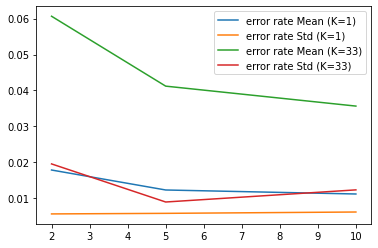

In [29]:
# Plot the dependency of the classification performance on L using KNNclassifier

plt.plot(L,MeanL1, label = "error rate Mean (K=1)")
plt.plot(L,DevL1, label = "error rate Std (K=1)")
plt.plot(L,MeanL33, label = "error rate Mean (K=33)")
plt.plot(L,DevL33, label = "error rate Std (K=33)")
plt.legend()
plt.show()


In [30]:
# Use sklearn library method: sklearn.neighbors.KNeighborsClassifier()

from sklearn.neighbors import KNeighborsClassifier


In [31]:
# Set K = [1]
MeanL1_skt, DevL1_skt = evaluateKNN(data=data, target=target, L=[2,5,10], K=[1], model=KNeighborsClassifier, stdout=True)
%timeit evaluateKNN(data=data, target=target, L=[2,5,10], K=[1], model=KNeighborsClassifier, stdout=False)


K Nearest Neighbor Classifier--> K = 1  : error rates = 0.02002
K Nearest Neighbor Classifier--> K = 1  : error rates = 0.0167
KNN classifier --> Fold = 2 : Error rate Mean = 0.018 ; Std = 0.00166
K Nearest Neighbor Classifier--> K = 1  : error rates = 0.01667
K Nearest Neighbor Classifier--> K = 1  : error rates = 0.01944
K Nearest Neighbor Classifier--> K = 1  : error rates = 0.01671
K Nearest Neighbor Classifier--> K = 1  : error rates = 0.00836
K Nearest Neighbor Classifier--> K = 1  : error rates = 0.00557
KNN classifier --> Fold = 5 : Error rate Mean = 0.013 ; Std = 0.00538
K Nearest Neighbor Classifier--> K = 1  : error rates = 0.00556
K Nearest Neighbor Classifier--> K = 1  : error rates = 0.01667
K Nearest Neighbor Classifier--> K = 1  : error rates = 0.01667
K Nearest Neighbor Classifier--> K = 1  : error rates = 0.00556
K Nearest Neighbor Classifier--> K = 1  : error rates = 0.01111
K Nearest Neighbor Classifier--> K = 1  : error rates = 0.02222
K Nearest Neighbor Classifier

In [32]:

# Set a bigger K = [33]
MeanL33_skt, DevL33_skt = evaluateKNN(data=data, target=target, L=[2,5,10], K=[33], model=KNeighborsClassifier, stdout=True)
%timeit evaluateKNN(data=data, target=target, L=[2,5,10], K=[33], model=KNeighborsClassifier, stdout=False)


K Nearest Neighbor Classifier--> K = 33  : error rates = 0.05895
K Nearest Neighbor Classifier--> K = 33  : error rates = 0.06013
KNN classifier --> Fold = 2 : Error rate Mean = 0.06 ; Std = 0.00059
K Nearest Neighbor Classifier--> K = 33  : error rates = 0.04167
K Nearest Neighbor Classifier--> K = 33  : error rates = 0.03333
K Nearest Neighbor Classifier--> K = 33  : error rates = 0.04457
K Nearest Neighbor Classifier--> K = 33  : error rates = 0.039
K Nearest Neighbor Classifier--> K = 33  : error rates = 0.04178
KNN classifier --> Fold = 5 : Error rate Mean = 0.04 ; Std = 0.0038
K Nearest Neighbor Classifier--> K = 33  : error rates = 0.02222
K Nearest Neighbor Classifier--> K = 33  : error rates = 0.02222
K Nearest Neighbor Classifier--> K = 33  : error rates = 0.03333
K Nearest Neighbor Classifier--> K = 33  : error rates = 0.04444
K Nearest Neighbor Classifier--> K = 33  : error rates = 0.01667
K Nearest Neighbor Classifier--> K = 33  : error rates = 0.03889
K Nearest Neighbor C

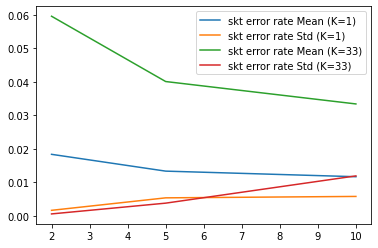

In [33]:
# Plot the dependency of the classification performance on L using sklearn library

plt.plot(L,MeanL1_skt, label = "skt error rate Mean (K=1)")
plt.plot(L,DevL1_skt, label = "skt error rate Std (K=1)")
plt.plot(L,MeanL33_skt, label = "skt error rate Mean (K=33)")
plt.plot(L,DevL33_skt, label = "skt error rate Std (K=33)")
plt.legend()
plt.show()
